In [40]:
from data_preprocessing.DataLoader import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import calendar

In [41]:
d = DataLoader.load_data_from_path("data")

In [42]:
products = d.products

In [43]:
# Splitting category_path into smaller categories, so it can be easier to group them and analyze each category separately

categories = products.category_path.str.split(';', expand=True)
products = pd.concat([products, categories], axis=1)
products = products.drop(columns=['category_path'])
products = products.rename(columns= {0: "primary_category", 1 :"secondary_category", 2 : "tertiary_category", 3 : "quaternary_category"})
products['price'] = products['price'].abs()

In [44]:
products.dtypes

product_id               int64
product_name            object
price                  float64
primary_category        object
secondary_category      object
tertiary_category       object
quaternary_category     object
dtype: object

In [45]:
products.describe()

,product_id,price
count,319.000000,3.190000e+02
mean,1160.000000,4.326200e+06
std,92.231593,4.010396e+07
min,1001.000000,1.000000e+00
25%,1080.500000,2.644500e+01
50%,1160.000000,4.999000e+01
75%,1239.500000,1.189500e+02
max,1319.000000,6.887800e+08


In [46]:
deliveries = d.deliveries

In [47]:
deliveries

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company
0,20001,2021-02-16 22:56:36,2021-02-21 00:39:10.536911,360.0
1,20002,2021-02-24 00:56:14,2021-02-27 14:05:55.281323,360.0
2,20003,2021-03-15 03:08:10,NaT,620.0
3,20004,2021-03-10 21:08:11,NaT,516.0
4,20005,2021-01-04 08:12:08,2021-01-03 05:46:20.558336,620.0
...,...,...,...,...
7035,27036,2021-01-13 23:58:40,2021-01-18 11:55:22.010087,516.0
7036,27037,2021-01-14 03:48:43,2021-01-16 15:59:29.566011,620.0
7037,27038,2021-02-25 12:52:33,2021-02-26 01:49:17.857426,516.0
7038,27039,2021-01-07 15:36:47,2021-01-05 12:16:35.844528,360.0


In [48]:
deliveries.dtypes

purchase_id                    int64
purchase_timestamp    datetime64[ns]
delivery_timestamp    datetime64[ns]
delivery_company             float64
dtype: object

In [49]:
deltas =  deliveries.delivery_timestamp - deliveries.purchase_timestamp 

In [50]:
deltas_clean = deltas.dropna()

In [51]:
deltas_clean

0        4 days 01:42:34.536911
1        3 days 13:09:41.281323
4      -2 days +21:34:12.558336
5        3 days 18:44:40.044368
6        0 days 08:48:38.427193
                 ...           
7035     4 days 11:56:42.010087
7036     2 days 12:10:46.566011
7037     0 days 12:56:44.857426
7038   -3 days +20:39:48.844528
7039   -1 days +15:20:47.532694
Length: 6672, dtype: timedelta64[ns]

In [52]:
deltas_clean_abs = deltas_clean.abs()

<AxesSubplot:ylabel='Frequency'>

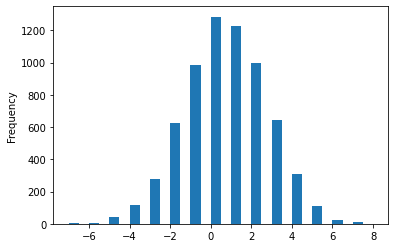

In [53]:
deltas_clean.astype('timedelta64[D]').plot.hist(bins = 30)

<AxesSubplot:ylabel='Frequency'>

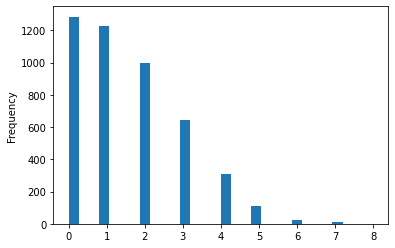

In [54]:
deltas_clean[deltas_clean>= pd.Timedelta(0)].astype('timedelta64[D]').plot.hist(bins = 30)

<AxesSubplot:ylabel='Frequency'>

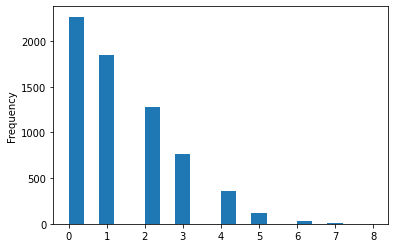

In [55]:
deltas_clean_abs.astype('timedelta64[D]').plot.hist(bins = 20)

In [56]:
deliveries["deltas"] = deltas.astype('timedelta64[D]')

In [57]:
deliveries_clean = deliveries.dropna()

In [58]:
import numpy as np

In [59]:
deliveries_clean.groupby("delivery_company")["deltas"].agg([np.mean,np.std])

,mean,std
delivery_company,,
360.0,0.485053,2.072962
516.0,0.528329,2.051740
620.0,0.506548,2.009850


<AxesSubplot:title={'center':'deltas'}, xlabel='delivery_company'>

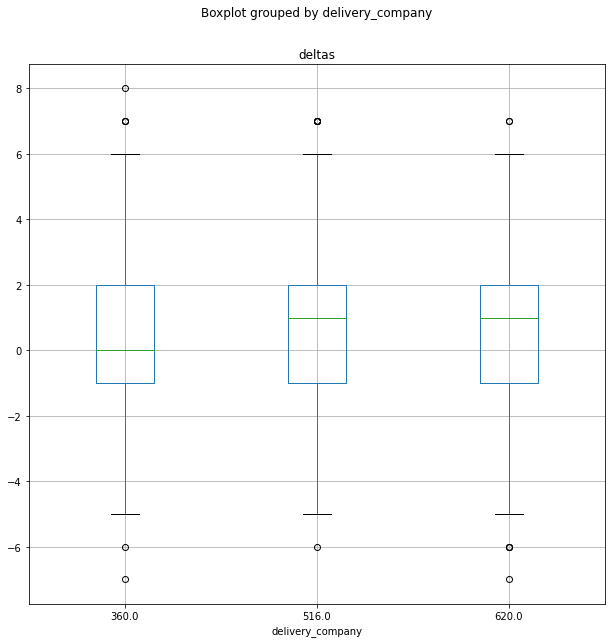

In [60]:
deliveries_clean.boxplot(column="deltas",by='delivery_company',figsize=(10,10))

In [61]:
deliveries.describe()

,purchase_id,delivery_company,deltas
count,7040.00000,6687.000000,6672.000000
mean,23520.50000,500.253028,0.506445
std,2032.41728,106.626291,2.043879
min,20001.00000,360.000000,-7.000000
25%,21760.75000,360.000000,-1.000000
50%,23520.50000,516.000000,0.000000
75%,25280.25000,620.000000,2.000000
max,27040.00000,620.000000,8.000000


Text(0, 0.5, 'User count')

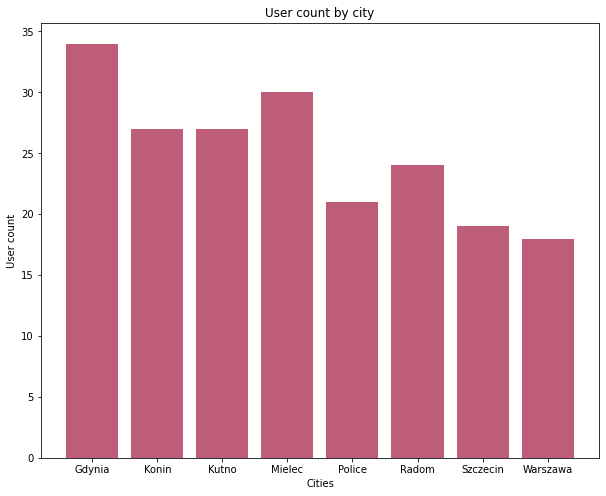

In [62]:
# Client location analysis - knowing where clients live is crucial to estimate delivery time
# The smaller the city is, the delivery time gets longer
cityCount = d.users.groupby('city', as_index=False).user_id.count()
plt.figure(figsize=(10, 8))
plt.bar(cityCount.city, cityCount.user_id, color='#BE5D77')
plt.title("User count by city")
plt.xlabel("Cities")
plt.ylabel("User count")

In [63]:
# Joining dataframes to further use in other plots
# We want to check whether there is a relationship between cities and delivery time.
deliveries_ses_user = deliveries_clean.merge(d.sessions[['user_id', 'purchase_id', 'product_id']], on='purchase_id')
deliveries_ses_user = deliveries_ses_user.merge(d.users[['user_id','city']], on='user_id')

<AxesSubplot:title={'center':'deltas'}, xlabel='city'>

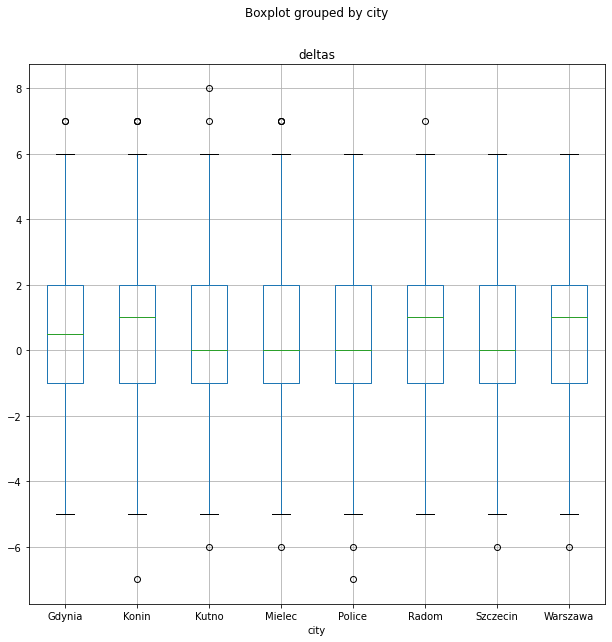

In [64]:
deliveries_ses_user.boxplot(column="deltas",by='city',figsize=(10,10))

Text(0, 0.5, 'Deliveries mean')

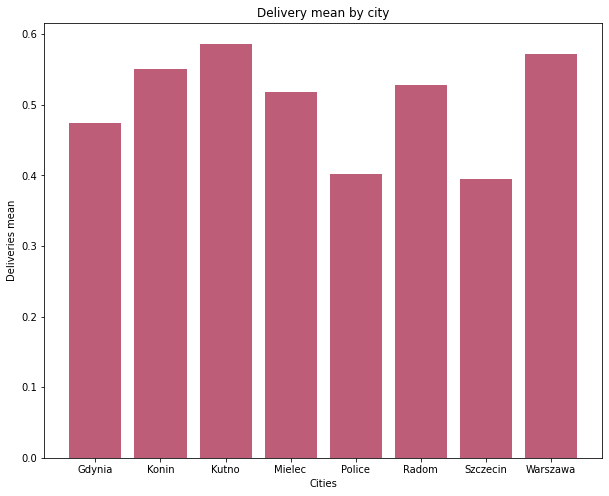

In [65]:
# Turned out boxplots weren't helpful so we check the mean for each city
deliveries_city = deliveries_ses_user.groupby('city', as_index=False).deltas.mean()
plt.figure(figsize=(10, 8))
plt.bar(deliveries_city.city, deliveries_city.deltas, color='#BE5D77')
plt.title("Delivery mean by city")
plt.xlabel("Cities")
plt.ylabel("Deliveries mean")

In [66]:
#Joining products dataframe to check the relationship between delivery time and product category.
deliveries_ses_user_prod = deliveries_ses_user.merge(products, on='product_id')


<AxesSubplot:title={'center':'deltas'}, xlabel='primary_category'>

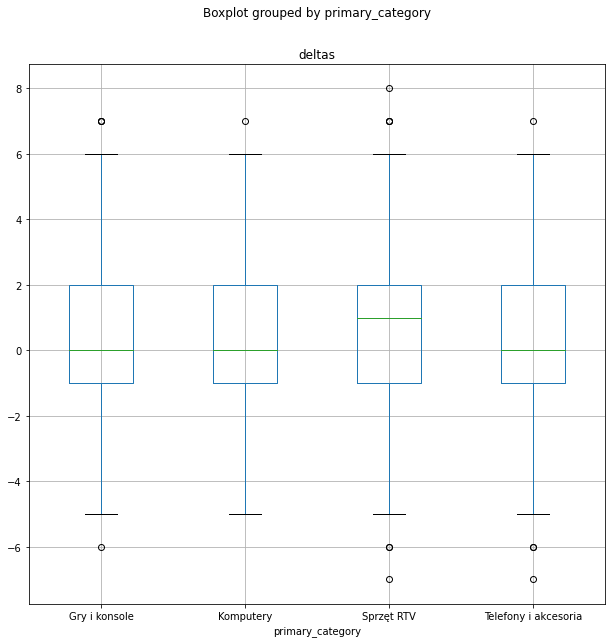

In [67]:
deliveries_ses_user_prod.boxplot(column="deltas",by='primary_category',figsize=(10,10))

Text(0, 0.5, 'Deliveries mean')

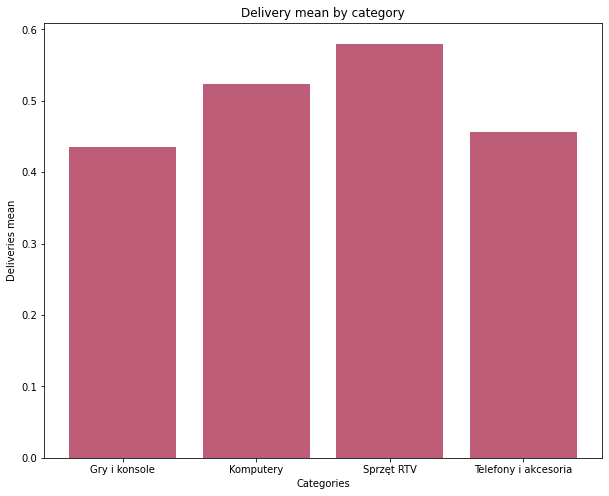

In [68]:
#Checking the mean for categories as well
deliveries_category = deliveries_ses_user_prod.groupby('primary_category', as_index=False).deltas.mean()
plt.figure(figsize=(10, 8))
plt.bar(deliveries_category.primary_category, deliveries_category.deltas, color='#BE5D77')
plt.title("Delivery mean by category")
plt.xlabel("Categories")
plt.ylabel("Deliveries mean")

<AxesSubplot:title={'center':'deltas'}, xlabel='weekday'>

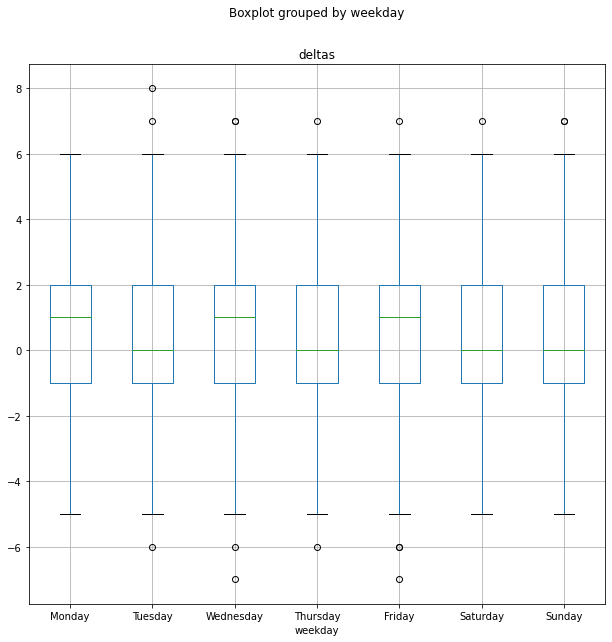

In [69]:
#Adding new column with day of the week and checking its relationship with delivery time
deliveries_ses_user_prod['weekday'] = deliveries_ses_user_prod['purchase_timestamp'].dt.day_name()
deliveries_ses_user_prod.boxplot(column="deltas",by='weekday',figsize=(10,10), positions=[4,0,5,6,3,1,2])


Text(0, 0.5, 'Deliveries mean')

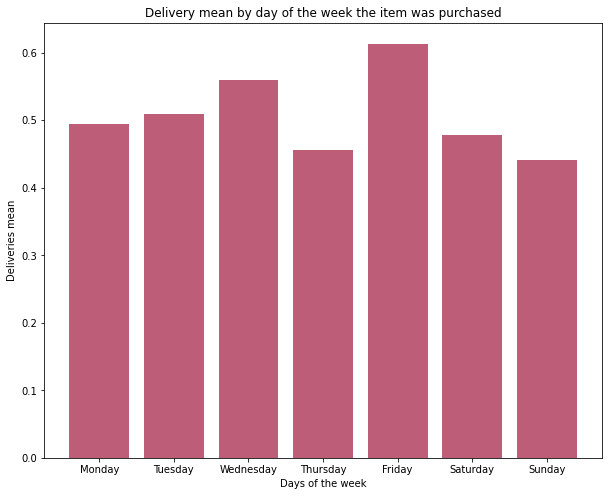

In [91]:
# No simple way to reorder the bars in matplotlib, so we had to use this trick
# We create an artificial key, by which we will sort dataframe
work_df = deliveries_ses_user_prod
work_df = work_df.groupby('weekday').deltas.mean().reset_index()
work_df = work_df.reindex([1,5,6,4,0,2,3])
plt.figure(figsize=(10, 8))

plt.bar(work_df.weekday, work_df.deltas, color='#BE5D77')
plt.title("Delivery mean by day of the week the item was purchased")
plt.xlabel("Days of the week")
plt.ylabel("Deliveries mean")

In [71]:
#Function for labeling rows
def labelTimeOfDay(row):
    hour = row['purchase_timestamp'].hour
    if(hour >= 6 and hour < 12):
        return "Morning"
    elif(hour >= 12 and hour < 18):
        return "Afternoon"
    elif(hour >=18 and hour < 24):
        return "Evening"
    else:
        return "Night"

In [72]:
#Using the function above to label all the rows
deliveries_clean.loc[:,'time_of_day'] = deliveries_clean.apply(lambda row: labelTimeOfDay(row), axis=1)

C:\Users\magda\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\magda\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


<AxesSubplot:title={'center':'deltas'}, xlabel='time_of_day'>

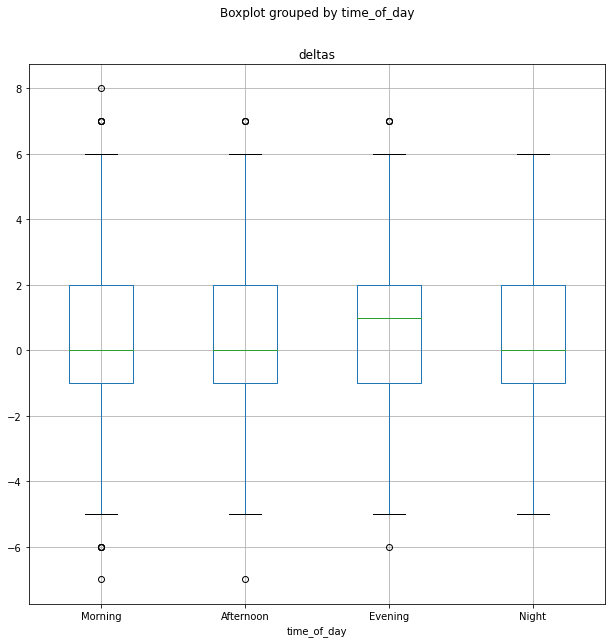

In [73]:
#Checking the relationship between the time of the day when we purchased the item and its delivery time
deliveries_clean.boxplot(column="deltas",by='time_of_day',figsize=(10,10), positions=[1,2,0,3])

Text(0, 0.5, 'Deliveries mean')

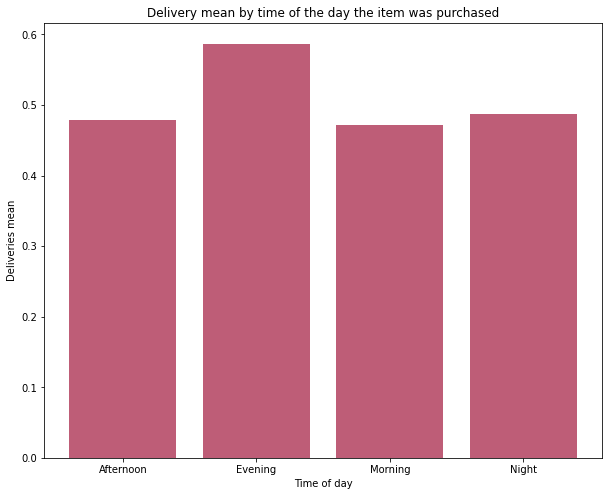

In [74]:
# Once again checking the mean for other clues
deliveries_clean = deliveries_clean.groupby('time_of_day', as_index=False).deltas.mean()
plt.figure(figsize=(10, 8))
plt.bar(deliveries_clean.time_of_day, deliveries_clean.deltas, color='#BE5D77')
plt.title("Delivery mean by time of the day the item was purchased")
plt.xlabel("Time of day")
plt.ylabel("Deliveries mean")

In [75]:
# Investigating negative values of delta column 
deliveries_ses_user_prod_neg = deliveries_ses_user_prod[deliveries_ses_user_prod['deltas'] < 0]

In [76]:
deliveries_ses_user_prod

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company,deltas,user_id,product_id,city,product_name,price,primary_category,secondary_category,tertiary_category,quaternary_category,weekday
0,20001,2021-02-16 22:56:36,2021-02-21 00:39:10.536911,360.0,4.0,102.0,1222.0,Kutno,Parrot Minikit NEO,245.0,Telefony i akcesoria,Akcesoria telefoniczne,Zestawy głośnomówiące,None,Tuesday
1,20033,2021-03-11 10:57:49,2021-03-09 08:32:30.845717,516.0,-3.0,102.0,1222.0,Kutno,Parrot Minikit NEO,245.0,Telefony i akcesoria,Akcesoria telefoniczne,Zestawy głośnomówiące,None,Thursday
2,20091,2021-01-19 15:28:12,2021-01-18 00:29:06.809978,620.0,-2.0,103.0,1222.0,Mielec,Parrot Minikit NEO,245.0,Telefony i akcesoria,Akcesoria telefoniczne,Zestawy głośnomówiące,None,Tuesday
3,20105,2021-01-28 13:18:51,2021-02-02 06:34:52.671013,360.0,4.0,103.0,1222.0,Mielec,Parrot Minikit NEO,245.0,Telefony i akcesoria,Akcesoria telefoniczne,Zestawy głośnomówiące,None,Thursday
4,20181,2021-01-11 13:21:20,2021-01-11 17:17:43.827780,360.0,0.0,108.0,1222.0,Gdynia,Parrot Minikit NEO,245.0,Telefony i akcesoria,Akcesoria telefoniczne,Zestawy głośnomówiące,None,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5697,25490,2021-03-10 21:26:02,2021-03-10 14:44:11.702221,620.0,-1.0,258.0,1040.0,Police,Crysis 2 (PS3),79.9,Gry i konsole,Gry na konsole,Gry PlayStation3,None,Wednesday
5698,25652,2021-01-21 12:04:38,2021-01-22 11:35:27.371368,620.0,0.0,263.0,1040.0,Mielec,Crysis 2 (PS3),79.9,Gry i konsole,Gry na konsole,Gry PlayStation3,None,Thursday
5699,25743,2021-03-14 17:50:14,2021-03-20 01:09:03.828943,516.0,5.0,265.0,1040.0,Police,Crysis 2 (PS3),79.9,Gry i konsole,Gry na konsole,Gry PlayStation3,None,Sunday
5700,25762,2021-02-05 02:21:59,2021-02-05 18:01:23.276859,360.0,0.0,266.0,1040.0,Mielec,Crysis 2 (PS3),79.9,Gry i konsole,Gry na konsole,Gry PlayStation3,None,Friday


In [77]:
# ROws with negative values represent around 31% of the whole dataset 
percent = len(deliveries_ses_user_prod_neg.index)/len(deliveries_ses_user_prod.index)
print(round(percent,2))

0.31
